# 1. Set-up

In [68]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

Saving ab_test_results_aggregated_views_clicks_8.csv to ab_test_results_aggregated_views_clicks_8 (1).csv


In [70]:
data = pd.read_csv(io.BytesIO(uploaded['ab_test_results_aggregated_views_clicks_8.csv']))


In [71]:
data.head()

,user_id,group,views,clicks
0,1,control,6.0,0.0
1,2,control,4.0,1.0
2,3,control,6.0,0.0
3,4,control,1.0,1.0
4,5,control,2.0,1.0


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  150000 non-null  int64  
 1   group    150000 non-null  object 
 2   views    150000 non-null  float64
 3   clicks   150000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.6+ MB


In [73]:
data.nunique()

user_id    150000
group           2
views         109
clicks         20
dtype: int64

In [74]:
data['group'].unique()

array(['control', 'test'], dtype=object)

Data contains aggregated data on the results of the experiment (user_id), treatment type (group: control and test) and key user metrics(number of views and number of clicks)

# 2. Does the test affect views, clicks?

In [75]:
data.groupby('group')[['views', 'clicks']].describe()

views                                                  clicks  \
           count      mean       std  min  25%  50%  75%    max    count   
group                                                                      
control  75000.0  4.990427  6.056919  1.0  2.0  3.0  6.0  443.0  75000.0   
test     75000.0  4.962387  5.696110  1.0  2.0  3.0  6.0  201.0  75000.0   

                                                       
             mean       std  min  25%  50%  75%   max  
group                                                  
control  0.476160  0.871567  0.0  0.0  0.0  1.0  42.0  
test     0.491173  0.876637  0.0  0.0  0.0  1.0  27.0

- About views, mean of test group is lower than control group. 
- About clicks, mean of test group is higher than control group.
- The max data point  of control is noticable high for both views and clicks.

In [76]:
# max views and clicks of control group
data[data['views'] == 443.0]

,user_id,group,views,clicks
37965,37966,control,443.0,42.0


In [77]:
# Data distribution by Empirical Cumulative distribution function
import numpy as np
import matplotlib.pyplot as plt

def ecdf(a):
  x = np.sort(a)
  y = np.arange(1, len(x) + 1) / len(x)
  return plt.plot(x, y, marker='.', linestyle='none')

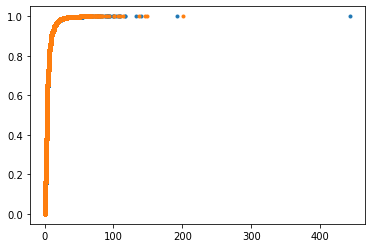

In [78]:
# views distribution
ecdf(data[data['group'] == 'control']['views'])
ecdf(data[data['group'] == 'test']['views'])

max view and click of control group is an outlier, let's remove it from the dataset and observe again the difference between two groups in term of views and clicks

In [79]:
exclude_max_of_control = data[data['views'] < 443.0]
exclude_max_of_control.groupby('group')[['views', 'clicks']].describe()

views                                                 clicks  \
           count      mean      std  min  25%  50%  75%    max    count   
group                                                                     
control  74999.0  4.984586  5.84197  1.0  2.0  3.0  6.0  192.0  74999.0   
test     75000.0  4.962387  5.69611  1.0  2.0  3.0  6.0  201.0  75000.0   

                                                       
             mean       std  min  25%  50%  75%   max  
group                                                  
control  0.475606  0.858282  0.0  0.0  0.0  1.0  18.0  
test     0.491173  0.876637  0.0  0.0  0.0  1.0  27.0

- About views, mean of test group is still lower than control group despite of higher max.
- About clicks, mean of test group is still higher than control group.
- Oulier does not affect the difference much.

From data: test decreased average views (from 4.990427 to 4.962387: -0.56%) but increased average clicks (from 0.476160 to 0.491173: 3.27%). The distribution of data has not changed significantly. 

Question: Are these differences due to chance?
=> check they are statistically significant or not with confidence level = 95% or alpha = 0.05

### a) Clicks

In [80]:
test_click = data[data['group'] == 'test']['clicks']
control_click = data[data['group'] == 'control']['clicks']

- Null hypothesis: the clicks is not affected by the test: mean(test_click) = mean(control_click)
- Alternative hypothesis: the clicks is affected by the test: mean(test_click) > mean(control_click)

In [81]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [82]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [83]:
def diff_of_means(A, B):
  return np.mean(A) - np.mean(B)


In [84]:
# Compute the observed difference in mean of the two groups
diff_obs_click = diff_of_means(test_click, control_click)

# Acquire 10,000 permutation replicates of difference in mean of the two groups: perm_replicates
perm_replicates_click = draw_perm_reps(test_click, control_click,
                                 diff_of_means, size=10000)

# Compute and print the p-value: p (the probability that we get the same or greater difference by chance if we take the data sample again 10000 times)
p = np.sum(perm_replicates_click >= diff_obs_click) / len(perm_replicates_click)
print('p-val-click =', p)

p-val-click = 0.0002


p-val-click < 0.05 => reject the null hypothesis => The test help increase the average clicks per user.

### b) Views

In [85]:
test_view = data[data['group'] == 'test']['views']
control_view = data[data['group'] == 'control']['views']

In [88]:
# Compute the observed difference in mean of the two groups
diff_obs_view = diff_of_means(test_view, control_view)

# Acquire 10,000 permutation replicates of difference in mean of the two groups: perm_replicates
perm_replicates_view = draw_perm_reps(test_view, control_view,
                                 diff_of_means, size=10000)

# Compute and print the p-value: p
p = np.sum(perm_replicates_view <= diff_obs_view) / len(perm_replicates_view)
print('p-val-view =', p)

p-val-view = 0.1648


p-val-view = 0.1648 > 0.05, the result is not statistically significant. Can not reject H0 => no conclusion on the effect of the test on the average views.